# CART: Classification and Regression Trees

<img src = 'images/louppe_2014_decision_tree.png' width = 80%>

Image source: Louppe, Gilles. Understanding random forests: From theory to practice. Diss. Universite de Liege (Belgium), 2014.

# Introduction and Dataset

## Background

This tutorial provides an example of how to apply classification and regression trees (CARTs), specifically random forest (RF) to model tree species. Here we will approach this challenge in two ways 1) classifying dominant tree species; and 2) regressing tree species proportions.

Estimating dominant tree species is a common task in forestry that is often performed using remote sensing such as in Fancini et al. (2024).

*Francini, Saverio, et al. "Forest species mapping and area proportion estimation combining Sentinel-2 harmonic predictors and national forest inventory data." International Journal of Applied Earth Observation and Geoinformation 131 (2024): 103935.*

## Tutorial goals

**Goal 1: Develop a random forest (RF) classification model to classify dominant tree species**

**Goal 2: Perform feature selection using scikit-learn and remove correlated predictors**

**Goal 3: Train RF for tree species classification using five-fold cross validation**

**Goal 4: Experiment with different hyperparameters to limit overfitting**

**Goal 5: Create a new model that performs species proportion regression and compare to the species classification model.**

-----

## Data

This tutorial makes use of light detection and ranging (LiDAR) metrics and multispectral indices that are derived in the Lasso and Ridge Regression Tutorial notebook. Specifically, the `predictors.csv` file generated contains all the predictor variables used in the current tutorial. Please refer to the Lasso and Ridge Regression tutorial for more information about how these metrics/indices were calculated.

# Install and load packages

**Uncomment the cell below to install required packages**

In [1]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install spyndex==0.5.0
# !pip install pyarrow==19.0.0

In [2]:
import os
import pandas as pd
import seaborn as sns

# Download data

In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['als_metrics.tif',
 'boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'petawawa_s2_2018.tif',
 'petawawa_s2_2024.tif',
 'plots.gpkg',
 'predictors.csv',
 'trees.csv',
 'water.gpkg']

In [4]:
# Calculate dominant tree species based on biomass

df = pd.read_csv("data/predictors.csv")

# Extract predictor var list
features_ls = df.drop("PlotName", axis=1).columns.tolist()

print("Predictor variables:")
print("\n".join(features_ls))

trees_df = pd.read_csv("data/trees.csv")

df

Predictor variables:
NDVI
NBR
SAVI
MSAVI
DSI
NDWI
GLI
ND705
NDREI
IRECI
TGI
avg_95
avg
b10
b20
b30
b40
b50
b60
b70
b80
b90
dns_10m
dns_12m
dns_14m
dns_15m
dns_16m
dns_18m
dns_20m
dns_25m
dns_2m
dns_4m
dns_5m
dns_6m
dns_8m
kur_95
p01
p05
p10
p20
p30
p40
p50
p60
p70
p80
p90
p95
p99
qav
skew_95
d0_2
d10_12
d12_14
d14_16
d16_18
d18_20
d20_22
d22_24
d24_26
d26_28
d28_30
d2_4
d30_32
d32_34
d34_36
d36_38
d38_40
d40_42
d42_44
d44_46
d46_48
d4_6
d6_8
d8_10
std_95
vci_1mbin
vci_0.5bin


,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,0.0,0.0,0.0,8.300000,0.0,0.0,1.170000,0.86,0.88
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,0.0,0.0,0.0,19.100000,8.0,2.2,6.650000,0.88,0.89
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,0.0,0.0,0.0,2.200000,3.4,11.8,5.000000,0.87,0.88
3,PRF017,0.832504,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,...,0.0,0.0,0.0,0.0,9.599999,5.0,3.8,6.140000,0.83,0.84
4,PRF018,0.764120,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,...,0.0,0.0,0.0,0.0,3.900000,2.7,2.9,6.980000,0.70,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,PRF183,0.857298,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,0.594032,...,9.7,2.7,1.5,0.1,1.100000,3.1,3.5,13.750000,0.94,0.95
235,PRF187,0.922648,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,0.733076,...,0.0,0.0,0.0,0.0,2.400000,4.2,3.4,9.820000,0.86,0.87
236,PRF209,0.829896,0.647397,0.315994,0.367099,0.462700,-0.693428,0.276003,0.527052,0.583441,...,0.0,0.0,0.0,0.0,2.200000,2.0,4.8,5.810000,0.83,0.86
237,PRF214,0.837961,0.559464,0.348880,0.410888,0.578021,-0.712261,0.303371,0.495551,0.532509,...,0.0,0.0,0.0,0.0,4.600000,5.1,5.5,9.929999,0.75,0.78


# Preprocessing

## Calculate dominant species in each plot based on biomass

In [5]:
# Remove trailing whitespace from species names
trees_df['species'] = trees_df['species'].str.strip()

# View the species composition across entire dataset by count
print(trees_df['species'].value_counts() / len(trees_df) * 100)

species
Balsam fir              14.694202
White pine              14.662431
Red (soft) maple        13.121525
Red pine                10.961080
Jack pine                4.741859
Red oak                  4.654488
White spruce             4.606831
Tamarack                 3.558380
Sugar Maple              3.510723
Trembling Aspen          3.161239
Ironwood                 1.969817
Norway Spruce            1.858618
American beech           1.858618
Black ash                1.787133
White birch              1.739476
Largetooth aspen         1.556791
Yellow birch             0.992851
Basswood                 0.683082
Northern white cedar     0.468626
Eastern hemlock          0.373312
White ash                0.182685
American elm             0.087371
Black cherry             0.087371
Balsam poplar            0.023828
Name: count, dtype: float64


In [6]:
# What can be said about the distribution of species? Describe species evenenss, richness, abundance, and overall diversity in this dataset.

# Tree Species Dominance

There are different ways of determining the dominant (i.e., leading) tree species in a given area. The simplest approach perhaps is to count the number of trees of a given species. However, this may not accurately represent dominance since one species may have many small trees that do not account for much volume or area.

Another approach is to calculate dominance based on volume or biomass. This means that a single massive tree may be dominant in a plot even if there are many more smaller trees.

Yet another approach is calculate dominance based on crown area or basal area. Crown area represents how much of the tree is seen from above (i.e., the crown). Basal area represents the area of the tree stem (i.e., trunk) at breast height.

In this tutorial, we will calculate dominance based on total tree volume. This is represented by the `tvol` column in the `trees.csv` dataset.

In [7]:
# Assign a new, unique ID for each tree
trees_df['tree_id'] = trees_df.index + 1

# Lets examine the distribution of species in the dataset
sp_agg = trees_df.groupby('species').agg(
    sp_count=('tree_id', 'count')).sort_values(by='sp_count', ascending=False)

sp_agg['sp_prop'] = sp_agg['sp_count'] / len(trees_df) * 100

sp_agg = round(sp_agg, 2)
print(f"{len(sp_agg)} species found in the dataset.")
print(sp_agg)

24 species found in the dataset.
                      sp_count  sp_prop
species                                
Balsam fir                1850    14.69
White pine                1846    14.66
Red (soft) maple          1652    13.12
Red pine                  1380    10.96
Jack pine                  597     4.74
Red oak                    586     4.65
White spruce               580     4.61
Tamarack                   448     3.56
Sugar Maple                442     3.51
Trembling Aspen            398     3.16
Ironwood                   248     1.97
Norway Spruce              234     1.86
American beech             234     1.86
Black ash                  225     1.79
White birch                219     1.74
Largetooth aspen           196     1.56
Yellow birch               125     0.99
Basswood                    86     0.68
Northern white cedar        59     0.47
Eastern hemlock             47     0.37
White ash                   23     0.18
American elm                11     0.09
Black c

In [8]:
# This dataset is quite unbalanced with 20/24 species having less than 5% of the total number of trees.

# This may make for a difficult classification task, but lets try.

In [9]:
# Calculate tree dominance based on volume


def calc_sp_dominance(trees, group_col='species'):

    trees_agg = trees.groupby(group_col).agg(sp_tvol=('tvol', 'sum'),)

    trees_agg['sp_vol_prop'] = trees_agg['sp_tvol'] / trees['tvol'].sum()

    # Sort in descending order by total volume
    trees_agg = trees_agg.sort_values(by='sp_tvol', ascending=False).reset_index()

    # Get the first row
    if len(trees_agg) == 0:
        print(f"No trees in plot: {trees['PlotName'].iloc[0]}")
        dom_sp = None        
    else:
        dom_sp = trees_agg[group_col].iloc[0]
    
    return(dom_sp)

for plot_nm in df['PlotName']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    dom_sp = calc_sp_dominance(trees_i, group_col='species')

    df.loc[df['PlotName'] == plot_nm, 'dom_sp'] = dom_sp

df

No trees in plot: PRF209


,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin,dom_sp
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,0.0,0.0,8.300000,0.0,0.0,1.170000,0.86,0.88,White pine
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,0.0,0.0,19.100000,8.0,2.2,6.650000,0.88,0.89,Jack pine
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,0.0,0.0,2.200000,3.4,11.8,5.000000,0.87,0.88,White pine
3,PRF017,0.832504,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,...,0.0,0.0,0.0,9.599999,5.0,3.8,6.140000,0.83,0.84,Jack pine
4,PRF018,0.764120,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,...,0.0,0.0,0.0,3.900000,2.7,2.9,6.980000,0.70,0.70,Jack pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,PRF183,0.857298,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,0.594032,...,2.7,1.5,0.1,1.100000,3.1,3.5,13.750000,0.94,0.95,White pine
235,PRF187,0.922648,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,0.733076,...,0.0,0.0,0.0,2.400000,4.2,3.4,9.820000,0.86,0.87,Largetooth aspen
236,PRF209,0.829896,0.647397,0.315994,0.367099,0.462700,-0.693428,0.276003,0.527052,0.583441,...,0.0,0.0,0.0,2.200000,2.0,4.8,5.810000,0.83,0.86,None
237,PRF214,0.837961,0.559464,0.348880,0.410888,0.578021,-0.712261,0.303371,0.495551,0.532509,...,0.0,0.0,0.0,4.600000,5.1,5.5,9.929999,0.75,0.78,White pine


In [10]:
# Remove plots which don't have trees
df = df[~df['dom_sp'].isna()]

# View distribution of dominant species
sp_dom_agg = df.groupby('dom_sp').agg(
    sp_count=('dom_sp', 'count')).sort_values(by='sp_count', ascending=False)

sp_dom_agg['sp_prop'] = sp_dom_agg['sp_count'] / len(df) * 100

sp_dom_agg = round(sp_dom_agg, 1)

print(sp_dom_agg)

                      sp_count  sp_prop
dom_sp                                 
White pine                  85     35.7
Red pine                    32     13.4
Red oak                     17      7.1
Tamarack                    17      7.1
Jack pine                   14      5.9
Sugar Maple                 11      4.6
Trembling Aspen             11      4.6
White spruce                10      4.2
Largetooth aspen             9      3.8
Red (soft) maple             9      3.8
Balsam fir                   7      2.9
American beech               4      1.7
Black ash                    3      1.3
Northern white cedar         3      1.3
Basswood                     2      0.8
Norway Spruce                2      0.8
Eastern hemlock              1      0.4
Yellow birch                 1      0.4


In [11]:
# Since some species are only dominant in one or two plots, we will remove these from the dataset to simplify the analysis

# Note that there are other ways of dealing with outliers such as this, but for the sake of simplicity we will just remove them

rare_species = sp_dom_agg[sp_dom_agg['sp_prop'] < 1].index.tolist()

print(f"Removing {len(rare_species)} rare species: {rare_species}")

df = df[~df['dom_sp'].isin(rare_species)]

df


Removing 4 rare species: ['Basswood', 'Norway Spruce', 'Eastern hemlock', 'Yellow birch']


,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin,dom_sp
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,0.0,0.0,8.300000,0.0,0.0,1.170000,0.86,0.88,White pine
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,0.0,0.0,19.100000,8.0,2.2,6.650000,0.88,0.89,Jack pine
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,0.0,0.0,2.200000,3.4,11.8,5.000000,0.87,0.88,White pine
3,PRF017,0.832504,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,...,0.0,0.0,0.0,9.599999,5.0,3.8,6.140000,0.83,0.84,Jack pine
4,PRF018,0.764120,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,...,0.0,0.0,0.0,3.900000,2.7,2.9,6.980000,0.70,0.70,Jack pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,PRF164,0.839857,0.687221,0.395382,0.472874,0.400071,-0.706024,0.300900,0.502832,0.583007,...,0.0,0.0,0.0,0.500000,0.8,1.0,11.080000,0.85,0.87,White pine
234,PRF183,0.857298,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,0.594032,...,2.7,1.5,0.1,1.100000,3.1,3.5,13.750000,0.94,0.95,White pine
235,PRF187,0.922648,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,0.733076,...,0.0,0.0,0.0,2.400000,4.2,3.4,9.820000,0.86,0.87,Largetooth aspen
237,PRF214,0.837961,0.559464,0.348880,0.410888,0.578021,-0.712261,0.303371,0.495551,0.532509,...,0.0,0.0,0.0,4.600000,5.1,5.5,9.929999,0.75,0.78,White pine


In [12]:
# Assign nummieric IDs to each dominant species
df['dom_sp_id'] = df['dom_sp'].astype('category').cat.codes

# Create a dictionary mapping species names to their IDs
dom_sp_dict = df[['dom_sp', 'dom_sp_id']].drop_duplicates().sort_values(by='dom_sp_id').set_index('dom_sp_id', drop=True).to_dict()['dom_sp']

dom_sp_dict

{0: 'American beech',
 1: 'Balsam fir',
 2: 'Black ash',
 3: 'Jack pine',
 4: 'Largetooth aspen',
 5: 'Northern white cedar',
 6: 'Red (soft) maple',
 7: 'Red oak',
 8: 'Red pine',
 9: 'Sugar Maple',
 10: 'Tamarack',
 11: 'Trembling Aspen',
 12: 'White pine',
 13: 'White spruce'}

# Classify Dominant Species

In [13]:
# Train a random forest model to predict dominant species based on predictors
from sklearn.model_selection import train_test_split

# Use simple train/test split using stratified sampling for now, apply cross-validation later 
train_df, test_df =  train_test_split(df[['dom_sp_id'] + features_ls], 
                 stratify=df['dom_sp_id'], 
                 test_size=0.3, 
                 random_state=25)

test_df

,dom_sp_id,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
188,12,0.891822,0.716678,0.500540,0.625359,0.357588,-0.786709,0.346066,0.560163,0.691303,...,0.0,0.0,0.0,0.0,3.5,3.100000,5.700000,8.860000,0.96,0.96
49,13,0.875178,0.668145,0.454660,0.558739,0.440426,-0.778859,0.288189,0.568081,0.647059,...,0.0,0.0,0.0,0.0,0.5,1.400000,3.100000,3.190000,0.79,0.83
110,1,0.764706,0.524927,0.229776,0.256080,0.599039,-0.662227,0.200758,0.364936,0.548003,...,0.0,0.0,0.0,0.0,2.4,1.400000,2.300000,11.389999,0.82,0.84
132,5,0.895674,0.680293,0.428484,0.526699,0.414094,-0.755006,0.386667,0.540540,0.620887,...,0.0,0.0,0.0,0.0,2.2,3.700000,3.700000,5.550000,0.90,0.91
36,12,0.893037,0.674253,0.409312,0.499290,0.457711,-0.776235,0.344713,0.552316,0.584906,...,0.0,0.0,0.0,0.0,4.3,18.199999,40.599998,2.910000,0.71,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,12,0.869736,0.748105,0.481082,0.592570,0.316872,-0.744691,0.325729,0.555990,0.636072,...,0.0,0.0,0.0,0.0,2.3,15.900000,48.000000,2.590000,0.74,0.79
24,8,0.894839,0.762149,0.421527,0.516753,0.334704,-0.795479,0.303922,0.623412,0.701793,...,0.0,0.0,0.0,0.0,1.0,0.600000,2.000000,4.180000,0.70,0.74
134,12,0.845106,0.670519,0.383768,0.458045,0.420480,-0.734400,0.265726,0.527677,0.613816,...,0.0,0.0,0.0,0.0,1.5,3.200000,6.500000,8.270000,0.93,0.93
158,12,0.913526,0.673838,0.501324,0.634206,0.432145,-0.802242,0.378472,0.585960,0.667089,...,0.0,0.0,0.0,0.0,6.5,4.500000,5.300000,7.510000,0.80,0.83


<Axes: xlabel='dom_sp_id', ylabel='Count'>

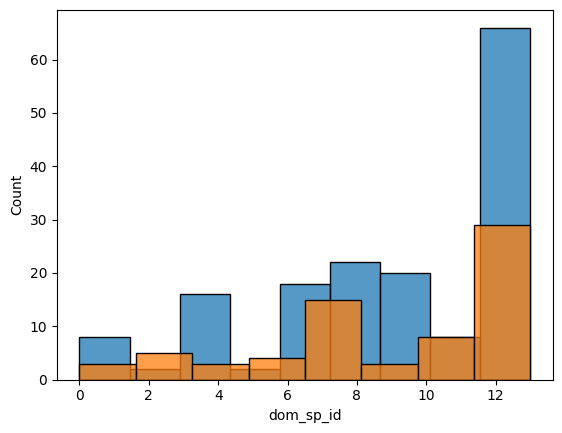

In [14]:
# Compare the distribution of dominant species in the training and test sets
sns.histplot(train_df['dom_sp_id'])
sns.histplot(test_df['dom_sp_id'])

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['dom_sp_id'])

# Apply the model to the test set
test_df['pred_dom_sp_id'] = rf.predict(test_df[features_ls])

# Calculate accuracy and kappa
from sklearn.metrics import accuracy_score, cohen_kappa_score

accuracy = accuracy_score(test_df['dom_sp_id'], test_df['pred_dom_sp_id'])
kappa = cohen_kappa_score(test_df['dom_sp_id'], test_df['pred_dom_sp_id'])

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.54


<Axes: >

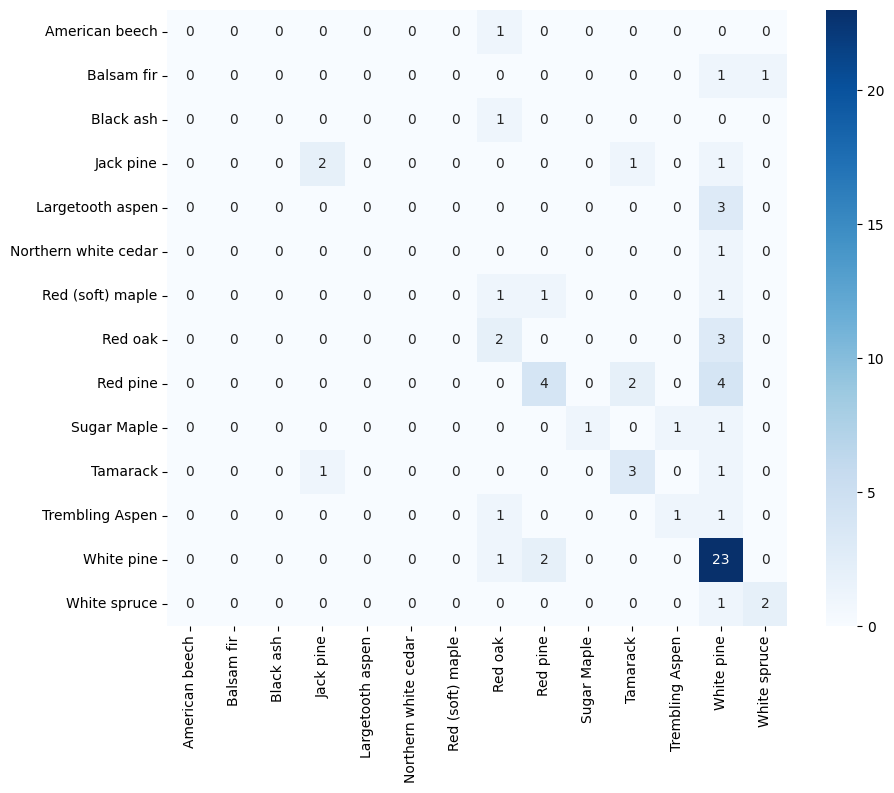

In [16]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_df['dom_sp_id'], test_df['pred_dom_sp_id'])
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dom_sp_dict.values(), 
            yticklabels=dom_sp_dict.values())

# Classify Dominant Tree Type (Coniferous/Deciduous)

In [17]:
# Let's simplify the problem and just classify whether a plot is broadleaf or deciduous

# Create a dict indicating whether a species is coniferous ('c') or deciduous ('d')
dom_sp_type_dict = {
    'Balsam fir': 'c',
    'White pine': 'c',
    'Red (soft) maple': 'd',
    'Red pine': 'c',
    'Jack pine': 'c',
    'Red oak': 'd',
    'White spruce': 'c',
    'Tamarack': 'c',
    'Sugar Maple': 'd',
    'Trembling Aspen': 'd',
    'Ironwood': 'd',
    'Norway Spruce': 'c',
    'American beech': 'd',
    'Black ash': 'd',
    'White birch': 'd',
    'Largetooth aspen': 'd',
    'Yellow birch': 'd',
    'Basswood': 'd',
    'Northern white cedar': 'c',
    'Eastern hemlock': 'c',
    'White ash': 'd',
    'American elm': 'd',
    'Black cherry': 'd',
    'Balsam poplar': 'd'
}

# Convert to df
sp_type_df = (pd.DataFrame.from_dict(dom_sp_type_dict, columns=['dom_sp_type'], orient='index')
              .reset_index()
              .rename(columns={'index': 'species'}))

# Join with trees
trees_df = trees_df.merge(sp_type_df, on='species', how='left')

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,tree_id,dom_sp_type
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles,1,c
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles,2,c
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large,3,c
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large,4,c
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large,5,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,NaN,Sugar Maple,N,L,3.7,NaN,NaN,8.893640,0.215043,N,0.000000,0.858564,851.191939,Under,12586,d
12586,PRF334,NaN,Sugar Maple,N,L,3.3,NaN,NaN,8.500000,0.171060,N,0.000000,0.653868,659.084439,Under,12587,d
12587,PRF334,NaN,Sugar Maple,N,L,3.2,NaN,NaN,8.395967,0.160850,N,0.000000,0.607493,615.333049,Under,12588,d
12588,PRF334,NaN,Sugar Maple,N,L,3.0,NaN,NaN,7.400000,0.141372,N,0.000000,0.469656,521.064025,Under,12589,d


In [18]:

for plot_nm in df['PlotName']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    dom_sp = calc_sp_dominance(trees_i, group_col='dom_sp_type')

    df.loc[df['PlotName'] == plot_nm, 'dom_sp_type'] = dom_sp

df

,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin,dom_sp,dom_sp_id,dom_sp_type
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,8.300000,0.0,0.0,1.170000,0.86,0.88,White pine,12,c
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,19.100000,8.0,2.2,6.650000,0.88,0.89,Jack pine,3,c
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,2.200000,3.4,11.8,5.000000,0.87,0.88,White pine,12,c
3,PRF017,0.832504,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,...,0.0,9.599999,5.0,3.8,6.140000,0.83,0.84,Jack pine,3,c
4,PRF018,0.764120,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,...,0.0,3.900000,2.7,2.9,6.980000,0.70,0.70,Jack pine,3,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,PRF164,0.839857,0.687221,0.395382,0.472874,0.400071,-0.706024,0.300900,0.502832,0.583007,...,0.0,0.500000,0.8,1.0,11.080000,0.85,0.87,White pine,12,c
234,PRF183,0.857298,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,0.594032,...,0.1,1.100000,3.1,3.5,13.750000,0.94,0.95,White pine,12,c
235,PRF187,0.922648,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,0.733076,...,0.0,2.400000,4.2,3.4,9.820000,0.86,0.87,Largetooth aspen,4,d
237,PRF214,0.837961,0.559464,0.348880,0.410888,0.578021,-0.712261,0.303371,0.495551,0.532509,...,0.0,4.600000,5.1,5.5,9.929999,0.75,0.78,White pine,12,c


In [19]:
# Summarize the proportion of each species type in the dataset
sp_type_agg = df.groupby('dom_sp_type').agg(
    sp_type_count=('dom_sp_type', 'count')).sort_values(by='sp_type_count', ascending=False)

sp_type_agg['sp_type_prop'] = round(sp_type_agg['sp_type_count'] / len(df) * 100, 0)

sp_type_agg

,sp_type_count,sp_type_prop
dom_sp_type,,
c,169,73.0
d,63,27.0


Accuracy: 0.90
Kappa: 0.74


<Axes: >

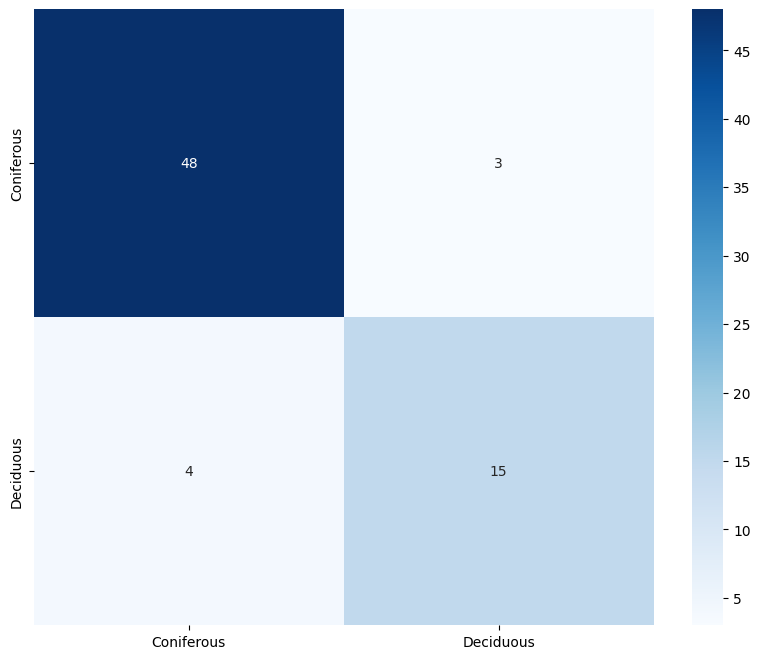

In [20]:
# Train a new random forest model to predict broadleaf vs coniferous

train_df, test_df =  train_test_split(df[['dom_sp_type'] + features_ls], 
                 stratify=df['dom_sp_type'], 
                 test_size=0.3, 
                 random_state=25)

rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['dom_sp_type'])

# Apply the model to the test set
test_df['pred_dom_sp_type'] = rf.predict(test_df[features_ls])

# Calculate accuracy and kappa
accuracy = accuracy_score(test_df['dom_sp_type'], test_df['pred_dom_sp_type'])
kappa = cohen_kappa_score(test_df['dom_sp_type'], test_df['pred_dom_sp_type'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Print confusion matrix

conf_matrix = confusion_matrix(test_df['dom_sp_type'], test_df['pred_dom_sp_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Coniferous', 'Deciduous'],
            yticklabels=['Coniferous', 'Deciduous'])


In [21]:
# Investigate the plots that were misclassified, why might this be?

# Regress Species Proportion

In [22]:
# Another method of modelling tree species is to regress the proportion of trees in a given plot

# This is more complex, but is effective when there is a key species of interest. This may be a species with high economic or ecological value, for example.

# To start, lets simply estimate the proportion of the most common species (Balsam Fir) in the dataset across all plots based on volume.

In [23]:
round(trees_df['species'].value_counts()/ len(trees_df) * 100, 2)

species
Balsam fir              14.69
White pine              14.66
Red (soft) maple        13.12
Red pine                10.96
Jack pine                4.74
Red oak                  4.65
White spruce             4.61
Tamarack                 3.56
Sugar Maple              3.51
Trembling Aspen          3.16
Ironwood                 1.97
Norway Spruce            1.86
American beech           1.86
Black ash                1.79
White birch              1.74
Largetooth aspen         1.56
Yellow birch             0.99
Basswood                 0.68
Northern white cedar     0.47
Eastern hemlock          0.37
White ash                0.18
American elm             0.09
Black cherry             0.09
Balsam poplar            0.02
Name: count, dtype: float64

Text(0, 0.5, 'Frequency')

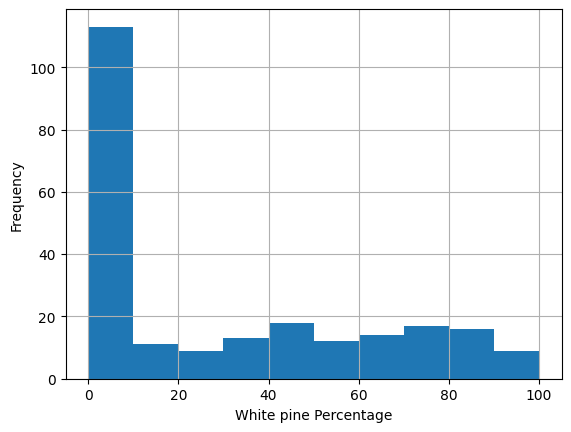

In [24]:
TARGET_SP = 'White pine'

def calc_target_sp_perc(trees, sp_nm):

    target_sp_trees = trees[trees['species'] == sp_nm].reset_index(drop=True)

    total_vol = trees['tvol'].sum()

    target_sp_tvol = target_sp_trees['tvol'].sum()

    target_sp_tvol_perc = round(target_sp_tvol / total_vol * 100, 2)
    
    return(target_sp_tvol_perc)

for plot_nm in df['PlotName']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    dom_sp = calc_target_sp_perc(trees_i, sp_nm=TARGET_SP)

    df.loc[df['PlotName'] == plot_nm, f'{TARGET_SP}_perc'] = dom_sp

df[f'{TARGET_SP}_perc'].hist()
plt.xlabel(f'{TARGET_SP} Percentage')
plt.ylabel('Frequency')

RMSE: 27.21
R^2: 0.27


Text(0, 0.5, 'Predicted White pine Percentage')

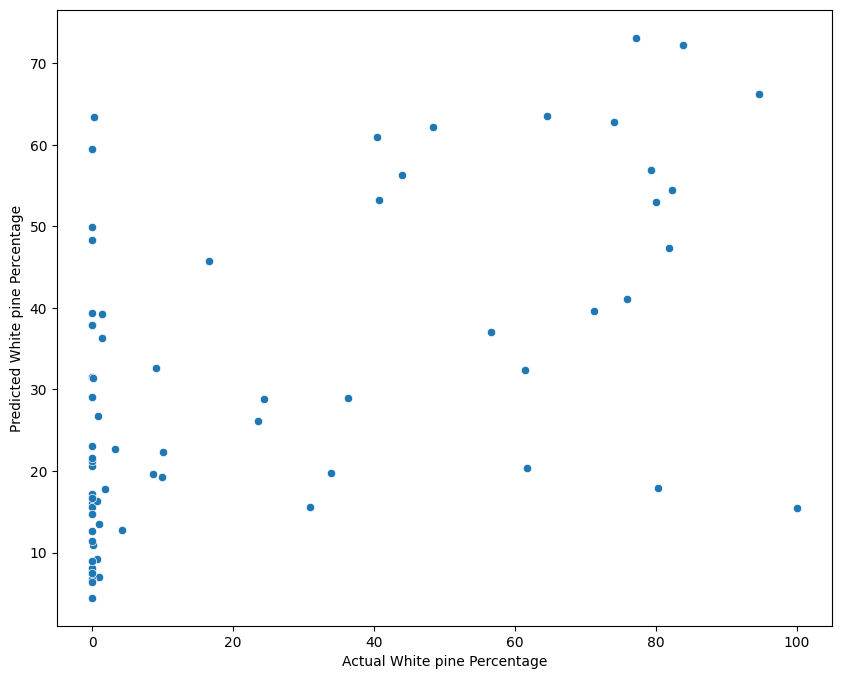

In [25]:
from sklearn.ensemble import RandomForestRegressor
from numpy import sqrt

# train a random forest model to predict balsam fir percentage

train_df, test_df =  train_test_split(df[[f'{TARGET_SP}_perc'] + features_ls], 
                                        test_size=0.3, 
                                        random_state=25)

rf = RandomForestRegressor(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df[f'{TARGET_SP}_perc'])

# Apply the model to the test set
test_df[f'pred_{TARGET_SP}_perc'] = rf.predict(test_df[features_ls])

# Calculate
from sklearn.metrics import mean_squared_error, r2_score

rmse = sqrt(mean_squared_error(test_df[f'{TARGET_SP}_perc'], test_df[f'pred_{TARGET_SP}_perc']))
r2 = r2_score(test_df[f'{TARGET_SP}_perc'], test_df[f'pred_{TARGET_SP}_perc'])

print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

# Plot the predicted vs actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_df[f'{TARGET_SP}_perc'], y=test_df[f'pred_{TARGET_SP}_perc'])
plt.xlabel(f'Actual {TARGET_SP} Percentage')
plt.ylabel(f'Predicted {TARGET_SP} Percentage')

# Add feature selection using a method from SKlearn:

https://scikit-learn.org/stable/modules/feature_selection.html
